In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx

#bring in feature correlation data
corr = pd.read_csv('Outputs/Top_LMP_Node_Correlations.csv', index_col = 0)

#create a column for utility
corr['Utility'] = corr['LMP node'].str.split(' ').str[0]

#pull utility data
area_info = pd.read_csv('data/cleaned/Geospatial_Mapping/miso_utilities_area_states.csv')

# Merge on 'Utility'
corr = corr.merge(area_info, on='Utility', how='inner')

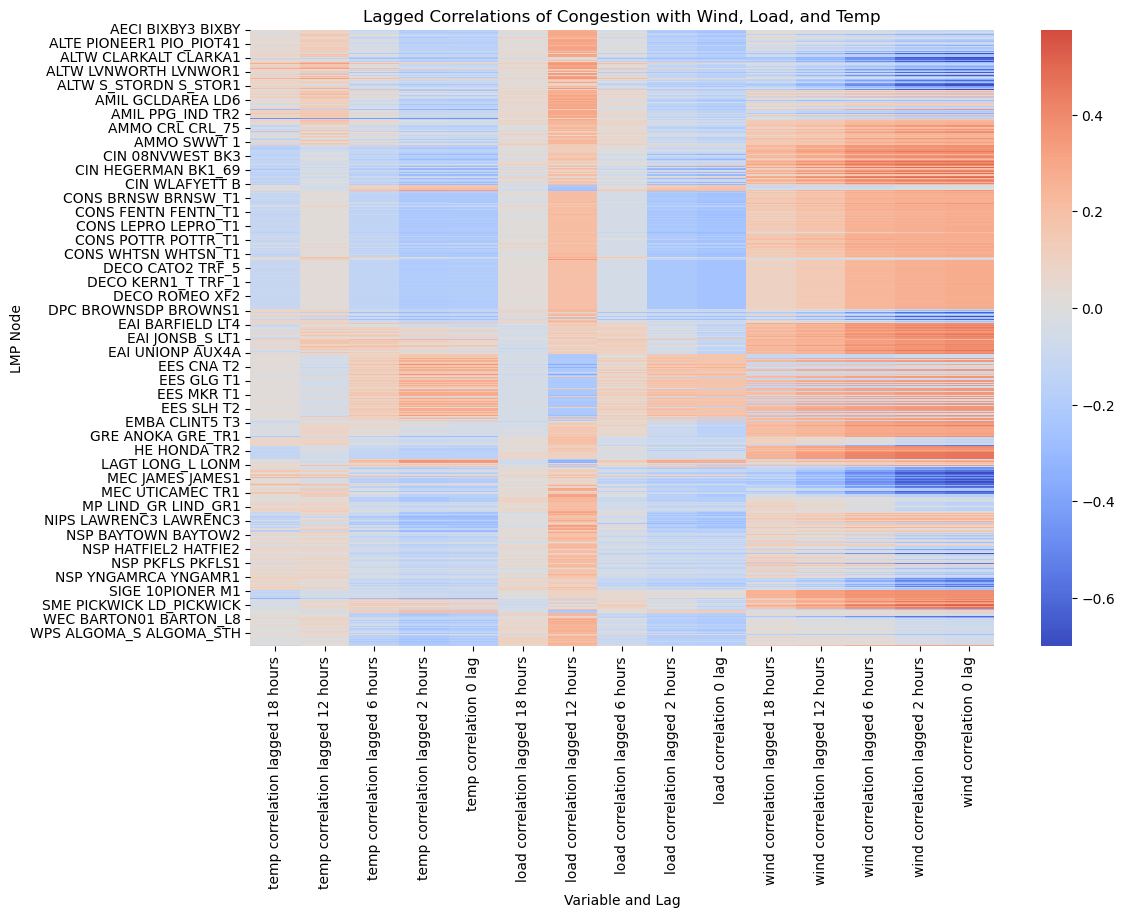

In [12]:
# Filter to wind/load/temp lag columns only
lagged_corrs = corr[[
    'temp correlation lagged 18 hours', 'temp correlation lagged 12 hours', 'temp correlation lagged 6 hours', 'temp correlation lagged 2 hours', 'temp correlation 0 lag',
    'load correlation lagged 18 hours', 'load correlation lagged 12 hours', 'load correlation lagged 6 hours', 'load correlation lagged 2 hours', 'load correlation 0 lag',
    'wind correlation lagged 18 hours', 'wind correlation lagged 12 hours', 'wind correlation lagged 6 hours', 'wind correlation lagged 2 hours', 'wind correlation 0 lag',
]]

# Set index to LMP node for labeling
lagged_corrs.index = corr['LMP node']

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(lagged_corrs, cmap='coolwarm', center=0)
plt.title('Lagged Correlations of Congestion with Wind, Load, and Temp')
plt.xlabel('Variable and Lag')
plt.ylabel('LMP Node')

plt.savefig('Outputs/MISO_Lagged_Congestion_Feature_Correlation.pdf', format='pdf', dpi=300, bbox_inches='tight')

# If you want to display the plot as well
plt.show()


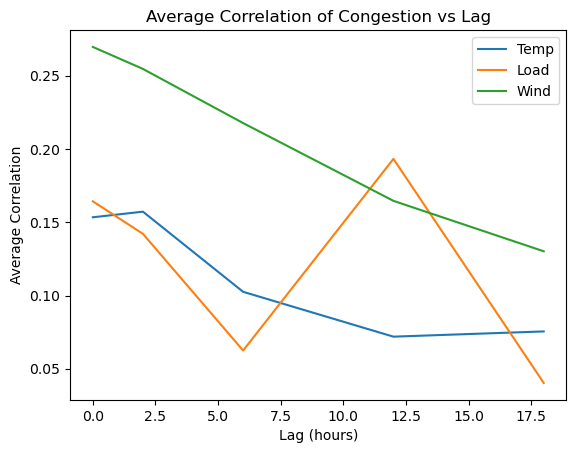

In [13]:
# Average correlations across all nodes for each lag
avg_corrs = {
    'Temp': abs(corr[[c for c in corr.columns if 'temp correlation' in c]]).mean(),
    'Load': abs(corr[[c for c in corr.columns if 'load correlation' in c]]).mean(),
    'Wind': abs(corr[[c for c in corr.columns if 'wind correlation' in c]]).mean()
}

# Plot
for var, corrs in avg_corrs.items():
    corrs.index = [int(s.split()[-2]) if 'lagged' in s else 0 for s in corrs.index]
    corrs = corrs.sort_index()
    plt.plot(corrs.index, corrs.values, label=var)

plt.title('Average Correlation of Congestion vs Lag')
plt.xlabel('Lag (hours)')
plt.ylabel('Average Correlation')
plt.legend()

plt.savefig('Outputs/MISO_Correlation_Vs_Lag_Strength.pdf', format='pdf', dpi=300, bbox_inches='tight')

# If you want to display the plot as well
plt.show()


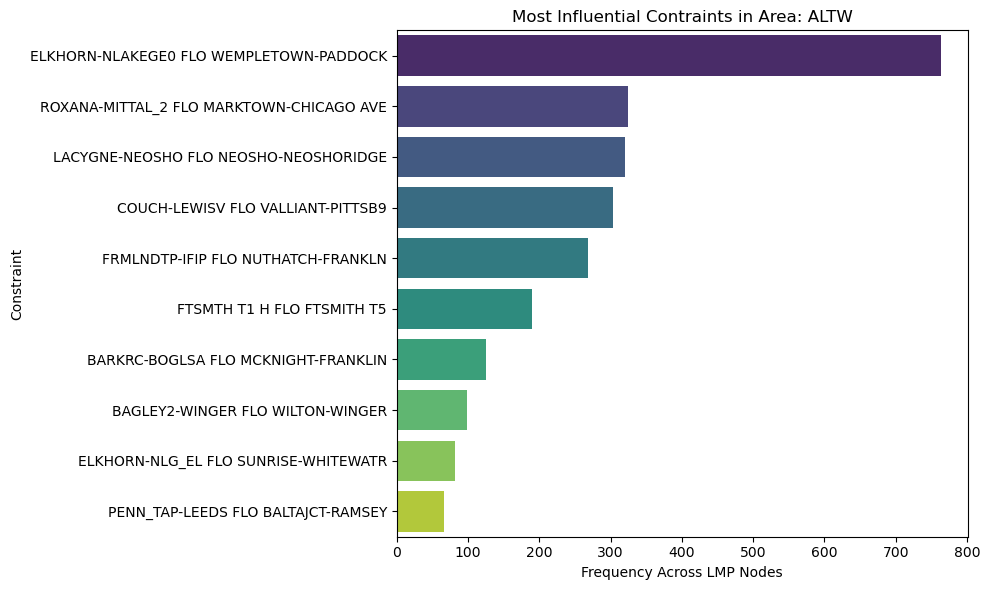

In [14]:
# Filter to one area
area_of_interest = 'ALTW'
area_df = corr[corr['Utility'] == area_of_interest]

# Stack constraints into one column
constraints = []
for i in range(1, 4):
    constraints += list(area_df[f'constraint_{i}'])

# Count constraint frequency
from collections import Counter
constraint_counts = Counter(constraints)
top_constraints = pd.DataFrame.from_dict(constraint_counts, orient='index', columns=['count']).sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(y=top_constraints.index[:10], x=top_constraints['count'][:10], palette='viridis')
plt.title(f'Most Influential Contraints in Area: {area_of_interest}')
plt.xlabel('Frequency Across LMP Nodes')
plt.ylabel('Constraint')
plt.tight_layout()

plt.savefig(f'Outputs/{area_of_interest}_Influential_constraints.pdf', format='pdf', dpi=300, bbox_inches='tight')

# If you want to display the plot as well
plt.show()


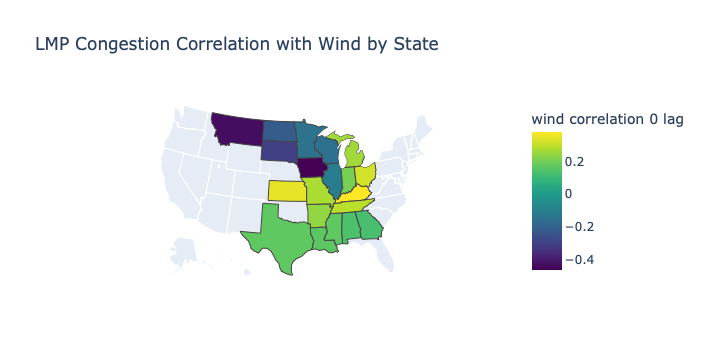

In [15]:
# If your merged DataFrame has a 'State' column as a set or list, you can explode it:
corr_geo = corr.copy()
corr_geo['State'] = corr_geo['State'].str.split('/')
corr_geo = corr_geo.explode('State')

# Then compute average correlation
state_avg_corr = corr_geo.groupby('State')["wind correlation 0 lag"].mean().reset_index()

fig = px.choropleth(
    state_avg_corr,
    title='LMP Congestion Correlation with Wind by State',
    locations='State',
    locationmode='USA-states',
    color='wind correlation 0 lag',
    scope='usa',
    color_continuous_scale='Viridis'
)

fig.write_image("Outputs/Wind_Congestion_Correlation_by_State.pdf", format="pdf")

fig.show()

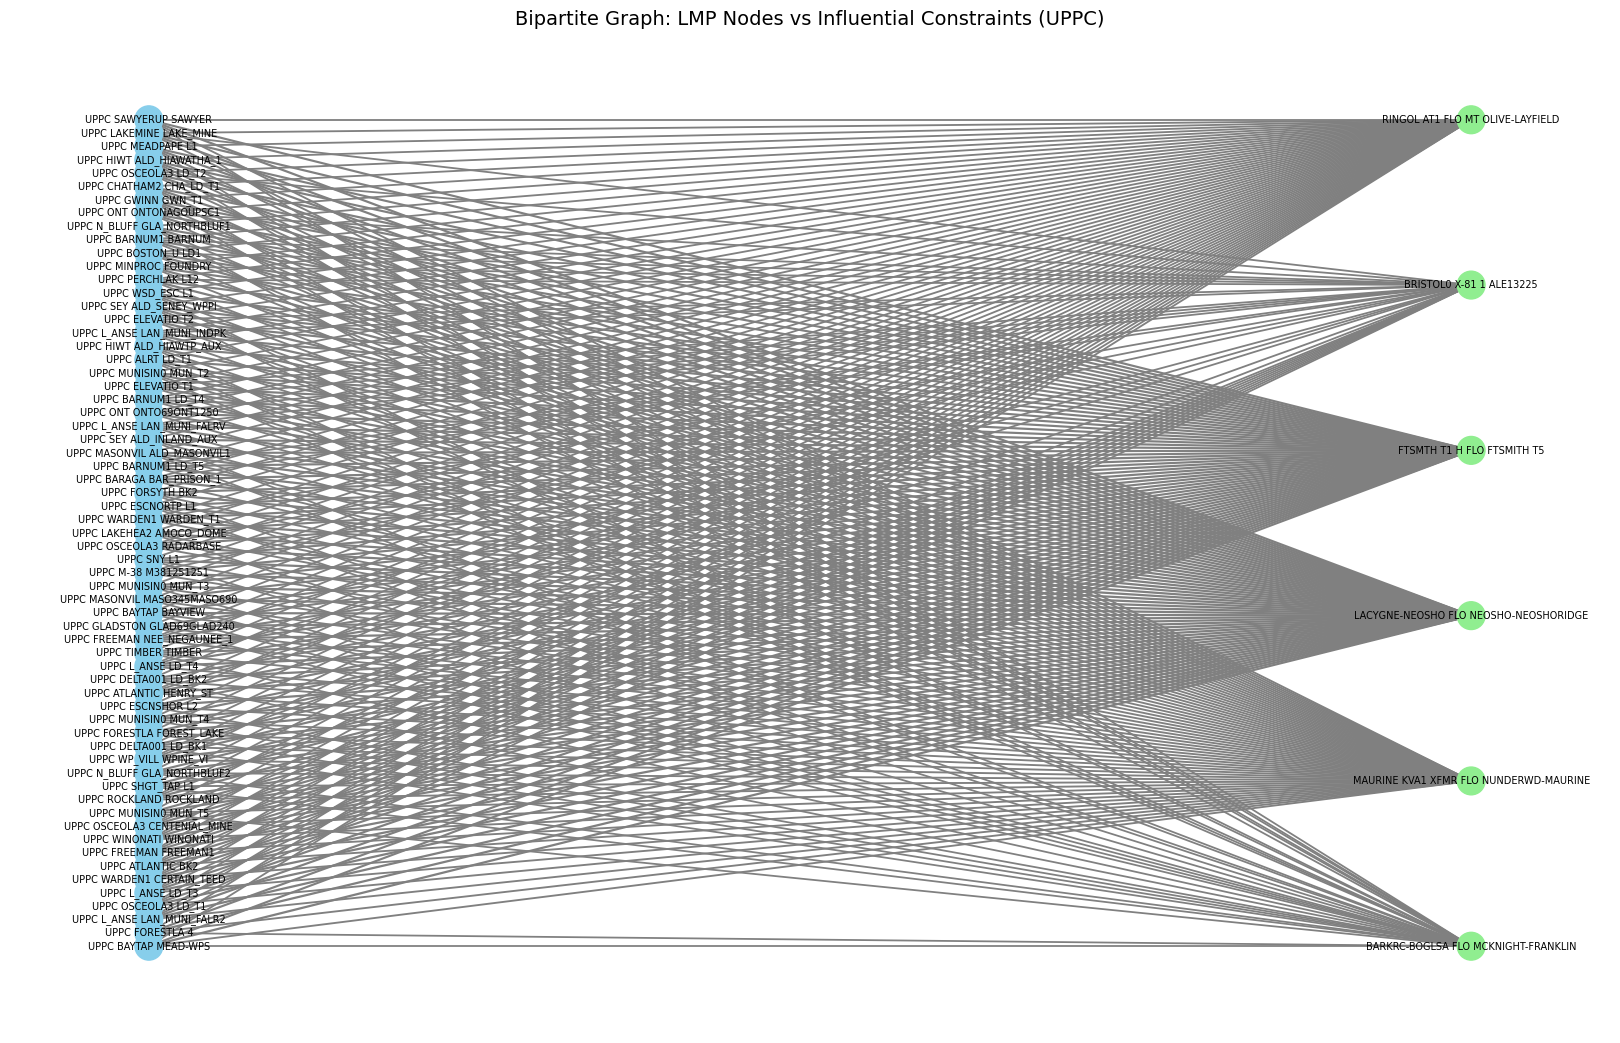

In [41]:
# Filter to one utility
corr1 = corr.loc[corr['Utility'] == 'UPPC', :]

# Create edge list and define node types
edges = []
lmp_nodes = set()
constraint_nodes = set()

for _, row in corr1.iterrows():
    lmp = row['LMP node']
    lmp_nodes.add(lmp)
    for i in range(1, 6):  # assuming 5 constraints
        constraint = row[f'constraint_{i}']
        weight = row[f'constraint_{i}_corr']
        constraint_nodes.add(constraint)
        edges.append((lmp, constraint, weight))

# Build bipartite graph
G = nx.Graph()
G.add_nodes_from(lmp_nodes, bipartite=0)  # LMP nodes
G.add_nodes_from(constraint_nodes, bipartite=1)  # Constraint nodes
G.add_weighted_edges_from(edges)

# Layout for bipartite - FIXED: using the correct function path
# The bipartite_layout function is directly in networkx.bipartite, not in networkx.algorithms.bipartite.layout
pos = nx.bipartite_layout(G, lmp_nodes)

# Draw the graph
plt.figure(figsize=(16, 10))
edge_weights = [abs(G[u][v]['weight']) * 2 for u, v in G.edges()]  # scale for visibility
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=400,
    font_size=7,
    width=edge_weights,
    edge_color='gray',
    node_color=['skyblue' if node in lmp_nodes else 'lightgreen' for node in G.nodes()]
)
plt.title("Bipartite Graph: LMP Nodes vs Influential Constraints (UPPC)", fontsize=14)

# Save the figure as PDF before showing it
plt.savefig("Outputs/Network_graph_UPPCO_constraints.pdf", format="pdf", bbox_inches="tight")

plt.show()